# Финальный ноутбук проекта

### Импорт сторонних библиотек

In [1]:
import re
import pandas as pd
import datatable as dt
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

### Загрузка данных

In [3]:
def read_fast_csv(data):
    frame = dt.fread(data)

    return frame.to_pandas()

df = read_fast_csv('data/ga_hits.csv')
df.head()

: 

In [2]:
df = pd.read_csv(
    'data/ga_hits.csv',
    )
df.shape

: 

In [1]:
df.head(5)

NameError: name 'df' is not defined

### Data Preparation

##### 1. Список колонок датасета

In [4]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer', 'title_status', 'transmission',
       'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
       'price_category', 'date'],
      dtype='object')

##### 2. Описательные статистики датасета

In [11]:
df.describe(include=[object])

,url,region,region_url,manufacturer,model,fuel,title_status,transmission,image_url,description,state,posting_date,price_category,date
count,10000,10000,10000,10000,9872,9937,9834,9955,9998,9998,10000,9998,10000,9998
unique,10000,393,405,40,3466,5,6,3,9081,9845,51,9911,3,9911
top,https://chattanooga.craigslist.org/ctd/d/chatt...,"kansas city, MO",https://kansascity.craigslist.org,ford,f-150,gas,clean,automatic,https://images.craigslist.org/00N0N_1xMPvfxRAI...,PLEASE VIEW THE FREE CARFAX HISTORY REPORT AT ...,ca,2021-04-22 11:01:24-04:00,high,2021-04-22 15:01:24+00:00
freq,1,86,86,1638,151,8402,9518,7700,188,7,1108,3,3495,3


In [12]:
df.describe(exclude=[object])

,id,price,year,odometer,lat,long
count,1.000000e+04,1.000000e+04,9964.0,10000.00000,9902.000000,9902.000000
mean,7.311541e+09,2.067842e+04,2010.927941,93324.13400,38.594142,-94.165877
std,4.477653e+06,1.246230e+05,9.67204,63181.17499,5.844895,18.128504
min,7.208550e+09,5.000000e+02,1915.0,0.00000,-67.144243,-158.069300
25%,7.308189e+09,7.900000e+03,2008.0,39147.25000,34.830368,-110.322086
50%,7.312757e+09,1.574950e+04,2013.0,89000.00000,39.298522,-88.000050
75%,7.315274e+09,2.799000e+04,2017.0,136875.00000,42.428070,-80.830000
max,7.317090e+09,1.234568e+07,2022.0,283466.00000,64.947500,173.885502


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   Int64  
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

Проверка на дубликаты

In [14]:
df[df.duplicated()]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date




Список всех признаков с пропущенными значениями:

In [15]:
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
print([column for column in missing_values[missing_values != 0].keys()])

['title_status', 'model', 'long', 'lat', 'fuel', 'transmission', 'year', 'posting_date', 'description', 'image_url', 'date']


Пропуски в posting_date

In [16]:
df[df['posting_date'].isna()].head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
6728,7315259025,https://nh.craigslist.org/cto/d/manchester-201...,new hampshire,https://nh.craigslist.org,3750,<NA>,other,NaN,NaN,95674,NaN,NaN,NaN,NaN,nh,NaN,NaN,NaT,low,NaN
9388,7208549803,https://bellingham.craigslist.org/ctd/d/bellin...,bellingham,https://bellingham.craigslist.org,11999,<NA>,other,NaN,NaN,95674,NaN,NaN,NaN,NaN,wa,NaN,NaN,NaT,medium,NaN


Эти строки решил удалить, слишком много пропущенных данных колонках

In [17]:
df.drop(index=[6728, 9388], axis=0, inplace=True)

Еще раз проверяю кол-во пропущенных значений в posting_date

In [18]:
print("Количество пропущенных значений в posting_date:", df['posting_date'].isna().sum())

Количество пропущенных значений в posting_date: 0


Пропуски в годе выпуска автомобиля

In [19]:
print(f"Количество пропущенных значений: {df.year.isna().sum()}")
df[df['year'].isna()].head()

Количество пропущенных значений: 34


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
344,7304102133,https://wenatchee.craigslist.org/ctd/d/wenatch...,wenatchee,https://wenatchee.craigslist.org,35880,<NA>,other,500,gas,13508,clean,automatic,https://images.craigslist.org/00J0J_6IMoEUzIIM...,2019 *Ram* *1500* Big Horn/Lone Star 4x2 Quad ...,wa,47.434493,-120.320759,2021-04-09 06:31:03-07:00,high,2021-04-09 13:31:03+00:00
420,7316337069,https://lasvegas.craigslist.org/ctd/d/scottsda...,las vegas,https://lasvegas.craigslist.org,84995,<NA>,other,Super Duty F-350 SRW,diesel,1268,clean,automatic,https://images.craigslist.org/00x0x_iQCC0Ef28S...,2020 *Ford* *Super Duty F-350 SRW* 1K MILES. B...,nv,33.458277,-111.925970,2021-05-03 11:31:39-07:00,high,2021-05-03 18:31:39+00:00
425,7315662117,https://westslope.craigslist.org/ctd/d/denver-...,western slope,https://westslope.craigslist.org,43900,<NA>,other,Grand Caravan,NaN,21,clean,automatic,https://images.craigslist.org/00f0f_7AwipNocNH...,"2019 *Dodge* *Grand Caravan* SE - $43,900Call ...",co,39.674406,-104.998604,2021-05-02 01:11:33-06:00,high,2021-05-02 07:11:33+00:00
702,7316199009,https://nashville.craigslist.org/ctd/d/nashvil...,nashville,https://nashville.craigslist.org,28498,<NA>,other,olet Silverado 1500,NaN,59246,NaN,automatic,https://images.craigslist.org/00T0T_dZ7nOXskCS...,2019 *Chevrolet* *Silverado 1500* 2019 CHEVROL...,tn,36.138022,-86.732261,2021-05-03 10:00:40-05:00,high,2021-05-03 15:00:40+00:00
893,7316840794,https://denver.craigslist.org/ctd/d/american-f...,denver,https://denver.craigslist.org,60900,<NA>,other,F-150,gas,6110,clean,automatic,https://images.craigslist.org/01616_bpzSdSRTbx...,"2020 *Ford* *F-150* PLATINUM FX4 Truck - $60,9...",co,40.362248,-111.785947,2021-05-04 12:11:22-06:00,high,2021-05-04 18:11:22+00:00


Часть пропущенных значений по году выпуска можно взять из описания автомобиля

In [20]:
def get_year(descrip):
    years = []
    for line in descrip:
        try:
            years.append(int(line.split(' ')[0]))
        except:
            # если в описании нет года выпуска, заполняю модой
            years.append(int(df['year'].mode().item()))
    
    return years

df_year = df[df['year'].isna()]
df_year['year'] = get_year(df_year['description'])

df.dropna(axis=0, subset=['year'], inplace=True)
df = pd.concat(
    [df, df_year]
    )
print(f"Количество пропущенных значений: {df.year.isna().sum()}")

Количество пропущенных значений: 0


/var/folders/3n/9btqzdsn4pj6vt892qs385w80000gn/T/ipykernel_33656/2914276729.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['year'] = get_year(df_year['description'])


Смотрю выбросы в годе выпуска автомобиля

In [21]:
df.year.describe()

count         9998.0
mean     2010.956191
std         9.667788
min           1915.0
25%           2008.0
50%           2013.0
75%           2017.0
max           2022.0
Name: year, dtype: Float64

Boxplot для выявления выбросов

Text(0.5, 0, 'boxplot для года выпуска автомобиля')

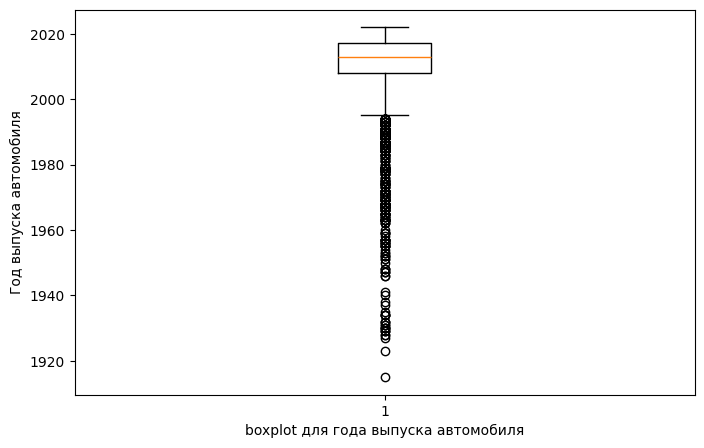

In [22]:
plt.figure(figsize=(8, 5))
plt.boxplot(df.year)
plt.ylabel('Год выпуска автомобиля')
plt.xlabel('boxplot для года выпуска автомобиля')

Границы для нормальных значений года выпуска

In [56]:
def calculate_quantile(data):
   q25 = data.year.quantile(0.25)
   q75 = data.year.quantile(0.75)

   return (q25, q75)

calculate_quantile(df)

(2008.0, 2017.0)

Количество выбросов в годе выпуска автомобиля

In [57]:
def calculate_outliers(data):
   q25 = data.year.quantile(0.25)
   q75 = data.year.quantile(0.75)
   iqr = q75 - q25

   return (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

boundaries = calculate_outliers(df)
is_outlier = ((df.year < boundaries[0]) | (df.year > boundaries[1]))

is_outlier.sum()

394

Записи, в которых год выпуска попадает в выбросы

In [58]:
df[is_outlier]

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
13,7317089086,https://seattle.craigslist.org/see/ctd/d/portl...,seattle-tacoma,https://seattle.craigslist.org,14995,1994,ford,e-series van universal by glaval designer luxu...,gas,156925,clean,automatic,https://images.craigslist.org/00r0r_13JUlXZOMl...,"Priced to Sell: $14,9951994 Ford E-Series Van ...",wa,45.391373,-122.613533,2021-05-04 20:22:11-07:00,medium,2021-05-05 03:22:11+00:00
21,7312327909,https://madison.craigslist.org/cto/d/madison-1...,madison,https://madison.craigslist.org,89995,1970,other,oldsmobile 442,gas,111111,clean,automatic,https://images.craigslist.org/00S0S_agk7Nol4CO...,1970 Oldsmobile 442 Convertible 442 Indy Pace ...,wi,43.098400,-89.273400,2021-04-25 10:10:43-05:00,high,2021-04-25 15:10:43+00:00
57,7314413105,https://inlandempire.craigslist.org/ctd/d/cost...,inland empire,https://inlandempire.craigslist.org,69888,1948,ford,coe,gas,1,clean,automatic,https://images.craigslist.org/00M0M_8jgBCZZuG6...,Awesome Resto-Mod COE Ford Car Hauler. Equippe...,ca,33.680100,-117.908500,2021-04-29 10:49:29-07:00,high,2021-04-29 17:49:29+00:00
66,7310077530,https://hudsonvalley.craigslist.org/cto/d/bloo...,hudson valley,https://hudsonvalley.craigslist.org,5500,1990,other,Diahatsu,gas,30000,clean,manual,https://images.craigslist.org/00T0T_a4VRbx40ea...,1991 Daihatsu hijet 5 speed extended cab....im...,ny,41.564400,-74.430400,2021-04-20 18:30:18-04:00,low,2021-04-20 22:30:18+00:00
106,7314527175,https://rapidcity.craigslist.org/ctd/d/sherman...,rapid city / west SD,https://rapidcity.craigslist.org,43500,1968,chevrolet,camaro,gas,43320,clean,manual,https://images.craigslist.org/00h0h_2N66LMJBAI...,1968 Chevrolet Camaro Convertible. VIN:124678N...,sd,33.637200,-96.618400,2021-04-29 15:11:01-06:00,high,2021-04-29 21:11:01+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,7313487583,https://springfield.craigslist.org/cto/d/mount...,springfield,https://springfield.craigslist.org,3500,1974,jeep,cj5,gas,10000,clean,manual,https://images.craigslist.org/00G0G_cdxzaTaVqa...,1974 Jeep cj5 304 v8 4speed manual trans Da...,mo,36.331200,-92.375300,2021-04-27 14:30:28-05:00,low,2021-04-27 19:30:28+00:00
9921,7311566144,https://chico.craigslist.org/cto/d/chico-1994-...,chico,https://chico.craigslist.org,16000,1994,ford,f250,gas,32500,clean,automatic,https://images.craigslist.org/01010_343KkgTaHo...,"Up for sale is this 32,000 original mile Ford ...",ca,39.745800,-121.844400,2021-04-23 13:51:20-07:00,medium,2021-04-23 20:51:20+00:00
9944,7313676859,https://reno.craigslist.org/ctd/d/sherman-1984...,reno / tahoe,https://reno.craigslist.org,26500,1984,chevrolet,silverado,gas,38751,clean,automatic,https://images.craigslist.org/00r0r_czXfi4UeJF...,"1984 Chevrolet C10 Silverado, short wheelbase ...",ca,33.637200,-96.618400,2021-04-27 19:44:27-07:00,high,2021-04-28 02:44:27+00:00
9972,7316458200,https://portland.craigslist.org/mlt/cto/d/port...,portland,https://portland.craigslist.org,18500,1972,chevrolet,NaN,gas,75000,clean,automatic,https://images.craigslist.org/00x0x_7FqS8iHJst...,1972 classic Chevrolet pick up custom deluxe ...,or,45.494960,-122.666988,2021-05-03 14:58:34-07:00,medium,2021-05-03 21:58:34+00:00


Заполняю выбросы нижней границей

In [59]:
df.loc[is_outlier, 'year'] = int(boundaries[0])

In [60]:
df.year.describe()

count         9998.0
mean     2011.695139
std         6.520938
min           1994.0
25%           2008.0
50%           2013.0
75%           2017.0
max           2022.0
Name: year, dtype: Float64

Смотрим пропуски в типе топлива

In [61]:
df['fuel'].value_counts(dropna=False)

fuel
gas         8402
other        730
diesel       653
hybrid       108
NaN           61
electric      44
Name: count, dtype: int64

Заполняю пропуски самым часто встречающимся значением

In [62]:
df.fuel = df.fuel.fillna(df['fuel'].mode().item())
print("Количество пропущенных значений в fuel:", df['fuel'].isna().sum())

Количество пропущенных значений в fuel: 0


Смотрим пропуски в типе трансмиссии

In [63]:
df['transmission'].value_counts(dropna=False)

transmission
automatic    7700
other        1624
manual        631
NaN            43
Name: count, dtype: int64

Заполняем пропуски самым часто встречающимся значением

In [64]:
df.transmission = df.transmission.fillna(df['transmission'].mode().item())
print("Количество пропущенных значений в transmission:", df['transmission'].isna().sum())

Количество пропущенных значений в transmission: 0


Поиск и заполнение пропущенных значений в title_status.

In [65]:
df['title_status'].value_counts(dropna=False)

title_status
clean         9518
rebuilt        171
NaN            164
salvage         92
lien            35
missing         16
parts only       2
Name: count, dtype: int64

Заполняю пропущенные значения модой

In [66]:
df.title_status = df.title_status.fillna(df['title_status'].mode().item())
print("Количество пропущенных значений в title_status:", df['title_status'].isna().sum())

Количество пропущенных значений в title_status: 0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9998 entries, 0 to 9953
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9998 non-null   int64  
 1   url             9998 non-null   object 
 2   region          9998 non-null   object 
 3   region_url      9998 non-null   object 
 4   price           9998 non-null   int64  
 5   year            9998 non-null   Int64  
 6   manufacturer    9998 non-null   object 
 7   model           9872 non-null   object 
 8   fuel            9998 non-null   object 
 9   odometer        9998 non-null   int64  
 10  title_status    9998 non-null   object 
 11  transmission    9998 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           9998 non-null   object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   object

Строки с пустыми значениями lat, long просто удалил. Информацию по ним не найти, да и заполнять их чем-то странно будет

In [68]:
df.dropna(axis=0, subset=['lat', 'long'], inplace=True)

Поиск и заполнение пропущенных значений в model

In [69]:
df['model'].value_counts(dropna=False)

model
f-150                     148
NaN                       126
silverado 1500            106
1500                      100
camry                      76
                         ... 
q50 2.0t luxe sedan 4d      1
forester xt                 1
range evoque hse            1
altima sl                   1
CX-5                        1
Name: count, Length: 3458, dtype: int64

In [70]:
unique_models = df['model'].unique()
unique_models

array(['2500 crew cab big horn', 'explorer 4wd 4dr xlt',
       'golf r hatchback', ..., 'u Impreza', 'ierra 2500HD', 'CX-5'],
      dtype=object)

Первые пять строк с пропущенными значениями в model

In [71]:
df[df['model'].isna()].head()


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
67,7316913641,https://ventura.craigslist.org/cto/d/camarillo...,ventura county,https://ventura.craigslist.org,3000,2005,rover,NaN,gas,165206,clean,automatic,https://images.craigslist.org/00S0S_b3yx6L4N2S...,2005 Range Rover HSE Changed Oil and now engi...,ca,34.219565,-119.001986,2021-05-04 13:11:15-07:00,low,2021-05-04 20:11:15+00:00
142,7316550853,https://chicago.craigslist.org/chc/cto/d/midlo...,chicago,https://chicago.craigslist.org,3000,2006,jeep,NaN,gas,132000,clean,automatic,https://images.craigslist.org/01111_kNv3EKjH4H...,SUPER CLEAN 2006 JEEP LIBEERY RANAGADE 4X4 O...,il,41.618957,-87.726334,2021-05-03 20:33:40-05:00,low,2021-05-04 01:33:40+00:00
151,7303575863,https://worcester.craigslist.org/ctd/d/fitchbu...,worcester / central MA,https://worcester.craigslist.org,7800,2007,gmc,NaN,gas,190000,clean,automatic,https://images.craigslist.org/00f0f_iWjiToqea2...,2007 gmc with plow leather loaded nice truck r...,ma,42.579600,-71.803100,2021-04-08 09:10:07-04:00,low,2021-04-08 13:10:07+00:00
200,7315267860,https://gainesville.craigslist.org/ctd/d/kissi...,gainesville,https://gainesville.craigslist.org,19200,2012,ram,NaN,gas,121371,clean,automatic,https://images.craigslist.org/00W0W_hHV4D0Po0G...,2012 RAM 1500 Laramie Crew Cab 2WD Offered...,fl,28.329026,-81.404237,2021-05-01 10:05:17-04:00,medium,2021-05-01 14:05:17+00:00
251,7316024407,https://reading.craigslist.org/ctd/d/paterson-...,reading,https://reading.craigslist.org,18695,2007,ram,NaN,diesel,220019,clean,automatic,https://images.craigslist.org/00n0n_jgq4eOvH7I...,2007 Dodge Ram 2500 SLT 4x4 Quad Cab Cummins D...,pa,40.894535,-74.152367,2021-05-02 21:06:09-04:00,medium,2021-05-03 01:06:09+00:00


Информация о модели автомобиля содержится в описании

Решил, что возьму уникальные значению всех моделей и пройдусь по каждому описанию. И если будет совпадение, то этим значением и заполню пропуск, а если нет, то осталю NaN

In [72]:
def get_models(descrip):
    model_list = []
    for desc in df_model.description:
        for model in unique_models:
            try:
                if re.search(fr'\b{model}\b', desc.lower()):
                    model_list.append(model)
                    break
            except:
                pass
        else:
            model_list.append(np.nan)
    
    return model_list


df_model = df[df['model'].isna()]
df_model['model'] = get_models(df_model.description)

/tmp/ipykernel_3363/3155105530.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['model'] = get_models(df_model.description)


In [73]:
df.dropna(subset=['model'], axis=0, inplace=True)

df = pd.concat(
    [df, df_model]
)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9902 entries, 0 to 9972
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9902 non-null   int64  
 1   url             9902 non-null   object 
 2   region          9902 non-null   object 
 3   region_url      9902 non-null   object 
 4   price           9902 non-null   int64  
 5   year            9902 non-null   Int64  
 6   manufacturer    9902 non-null   object 
 7   model           9902 non-null   object 
 8   fuel            9902 non-null   object 
 9   odometer        9902 non-null   int64  
 10  title_status    9902 non-null   object 
 11  transmission    9902 non-null   object 
 12  image_url       9902 non-null   object 
 13  description     9902 non-null   object 
 14  state           9902 non-null   object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9902 non-null   object

Boxplot для количества пройденных миль

Text(0.5, 0, 'boxplot для кол-ва пройденных миль')

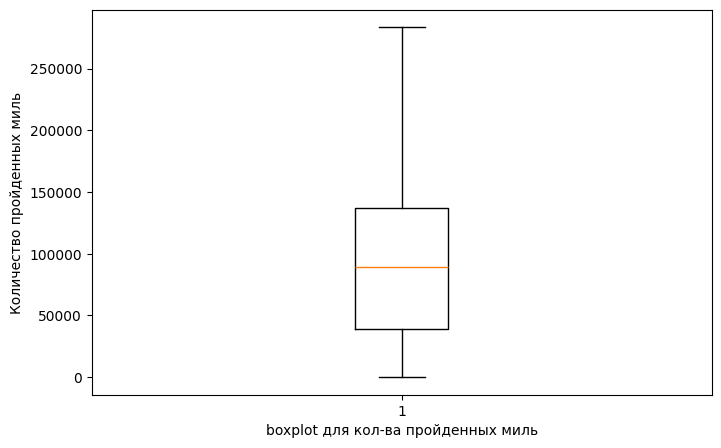

In [23]:
plt.figure(figsize=(8, 5))
plt.boxplot(df.odometer)
plt.ylabel('Количество пройденных миль')
plt.xlabel('boxplot для кол-ва пройденных миль')

## Feature engineering

Смотрим количество уникальных значений модели

In [75]:
len(df.model.unique())

3457

Уменьшаем количество уникальных значений (просте оставляю первое слово из название модели)

In [76]:
df["short_model"] = df.model.apply(lambda x: x.split(" ")[0])
print(f"Количество уникальных значений: {len(df.short_model.unique())}")

Количество уникальных значений: 985


Добавил age_category

In [77]:
df['age_category'] =  df.apply(lambda x: "new" if x.year > 2013 else ("old" if x.year < 2006 else "average"), axis=1)
df['age_category']

0           new
1           new
2           new
3       average
4           new
         ...   
9564    average
9616    average
9670        old
9926        new
9972        old
Name: age_category, Length: 9902, dtype: object

### Преобразование категориальных переменных

In [78]:
variables = [
    "short_model",
    "transmission",
    "region",
    "manufacturer",
    "state",
    "title_status",
    "age_category"
]

for variable in variables:
    print(
        f"Количество уникальных значений {df[variable].name}: {len(df[variable].unique())}"
    )

Количество уникальных значений short_model: 985
Количество уникальных значений transmission: 3
Количество уникальных значений region: 393
Количество уникальных значений manufacturer: 40
Количество уникальных значений state: 51
Количество уникальных значений title_status: 6
Количество уникальных значений age_category: 3


Создаю дадафрейм только с необходимыми переменными

In [83]:
data = df[variables]
data

,short_model,transmission,region,manufacturer,state,title_status,age_category
0,2500,other,chattanooga,ram,tn,clean,new
1,explorer,automatic,north jersey,ford,nj,clean,new
2,golf,other,reno / tahoe,volkswagen,ca,clean,new
3,rav4,automatic,fayetteville,toyota,nc,clean,average
4,altima,automatic,new york city,nissan,ny,clean,new
...,...,...,...,...,...,...,...
9564,prius,automatic,des moines,toyota,ia,clean,average
9616,tahoe,automatic,vermont,ram,vt,clean,average
9670,savana,automatic,louisville,gmc,ky,clean,old
9926,hse,automatic,tulsa,rover,ok,clean,new


Преобразую катгориальные переменные с помощью OnrHotEncoder

In [84]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(data[variables])
ohe_data = ohe.transform(data)
print(ohe_data.shape)
ohe_data

(9902, 1481)


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Дополняю датафрейм перобразованными переменными

In [85]:
df[ohe.get_feature_names_out()] = ohe_data
df.head(5)

/tmp/ipykernel_3363/3830920143.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe_data
/tmp/ipykernel_3363/3830920143.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ohe.get_feature_names_out()] = ohe_data
/tmp/ipykernel_3363/3830920143.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,state_wy,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,age_category_average,age_category_new,age_category_old
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,gas,60023,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Создаю новую переменную с месяцем из даты подачи объявления

In [87]:
df.posting_date

0       2021-04-17 12:30:50-04:00
1       2021-05-03 15:40:21-04:00
2       2021-04-28 03:52:20-07:00
3       2021-04-17 10:08:57-04:00
4       2021-05-03 18:32:06-04:00
                  ...            
9564    2021-04-29 10:50:54-05:00
9616    2021-04-09 16:24:23-04:00
9670    2021-04-20 04:48:30-04:00
9926    2021-05-03 16:37:36-05:00
9972    2021-05-03 14:58:34-07:00
Name: posting_date, Length: 9902, dtype: object

In [81]:
df['month'] = df.date.apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.month

0       4
1       5
2       4
3       4
4       5
       ..
9564    4
9616    4
9670    4
9926    5
9972    5
Name: month, Length: 9902, dtype: int64

Создаю переменную с возрастом автомобиля

In [82]:
df['diff_years'] = df.date.apply(lambda x: int(x.split(' ')[0].split('-')[0])) - df.year
df.diff_years

0        1
1        5
2        4
3        8
4        0
        ..
9564    14
9616     9
9670    16
9926     4
9972    27
Name: diff_years, Length: 9902, dtype: Int64

Преобразую количественные переменные

In [90]:
columns_list = [
    "lat",
    "long",
    "year",
    "diff_years",
    "month"
]
columns_std = [col + '_std' for col in columns_list]

data_num = df[columns_list]
data_num

,lat,long,year,diff_years,month
0,35.060000,-85.250000,2020,1,4
1,40.821805,-74.061962,2016,5,5
2,33.779214,-84.411811,2017,4,4
3,35.715954,-78.655304,2013,8,4
4,40.654800,-73.609700,2021,0,5
...,...,...,...,...,...
9564,41.629500,-93.723000,2007,14,4
9616,42.788204,-71.233728,2012,9,4
9670,37.858900,-86.006900,2005,16,4
9926,36.126200,-95.940800,2017,4,5


Для преобразования количественных переменных использую StandartScaler

In [91]:
std_scaler = StandardScaler()
std_scaler.fit(data_num)
std_scaler_new = std_scaler.transform(data_num)
std_scaler_new


array([[-0.604685  ,  0.49184024,  1.27253982, -1.27253982, -0.61447029],
       [ 0.38114891,  1.10902316,  0.66041758, -0.66041758,  1.62741799],
       [-0.82382506,  0.53807855,  0.81344814, -0.81344814, -0.61447029],
       ...,
       [-0.12579852,  0.4500862 , -1.02291858,  1.02291858, -0.61447029],
       [-0.4222602 , -0.09791278,  0.81344814, -0.81344814,  1.62741799],
       [ 1.18071687, -1.57225053, -2.70625474,  2.70625474,  1.62741799]])

Добавляю новые фичи в исходный датасет

In [92]:
df[columns_std] = std_scaler_new
print(df.columns.to_list())
df.head(5)

['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission', 'image_url', 'description', 'state', 'lat', 'long', 'posting_date', 'price_category', 'date', 'short_model', 'age_category', 'month', 'diff_years', 'short_model_-benz', 'short_model_1', 'short_model_124', 'short_model_128i', 'short_model_135i', 'short_model_1500', 'short_model_163869', 'short_model_1928', 'short_model_1951', 'short_model_1954', 'short_model_1960s', 'short_model_1966', 'short_model_1968', 'short_model_1972', 'short_model_1977', 'short_model_1978', 'short_model_198.5', 'short_model_1988', 'short_model_1994', 'short_model_1999', 'short_model_2', 'short_model_200', 'short_model_2000', 'short_model_2002', 'short_model_2006', 'short_model_2007', 'short_model_2008', 'short_model_2009', 'short_model_2012', 'short_model_2015', 'short_model_2016', 'short_model_2017', 'short_model_2018', 'short_model_2021', 'short_model_210', 'short_model_240', 'shor

/tmp/ipykernel_3363/749244879.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[columns_std] = std_scaler_new
/tmp/ipykernel_3363/749244879.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[columns_std] = std_scaler_new
/tmp/ipykernel_3363/749244879.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,title_status_rebuilt,title_status_salvage,age_category_average,age_category_new,age_category_old,lat_std,long_std,year_std,diff_years_std,month_std
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020,ram,2500 crew cab big horn,diesel,27442,...,0.0,0.0,0.0,1.0,0.0,-0.604685,0.491840,1.272540,-1.272540,-0.614470
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016,ford,explorer 4wd 4dr xlt,gas,60023,...,0.0,0.0,0.0,1.0,0.0,0.381149,1.109023,0.660418,-0.660418,1.627418
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017,volkswagen,golf r hatchback,gas,14048,...,0.0,0.0,0.0,1.0,0.0,-0.823825,0.538079,0.813448,-0.813448,-0.614470
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013,toyota,rav4,gas,117291,...,0.0,0.0,1.0,0.0,0.0,-0.492453,0.855634,0.201326,-0.201326,-0.614470
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021,nissan,altima,gas,8000,...,0.0,0.0,0.0,1.0,0.0,0.352575,1.133972,1.425570,-1.425570,1.627418


Удаляю лишние колонки (переменные без преобразования)

In [93]:
columns_for_drop = [
    "year",
    "url",
    "region",
    "region_url",
    "manufacturer",
    "model",
    "fuel",
    "odometer",
    "title_status",
    "transmission",
    "image_url",
    "description",
    "state",
    "lat",
    "long",
    "posting_date",
    "age_category",
    "short_model",
    "date",
    "month",
    "diff_years",
]

df_prepared = df.drop(columns=columns_for_drop)

In [94]:
print(df_prepared.shape)
df_prepared.columns.to_list()

(9902, 1489)


['id',
 'price',
 'price_category',
 'short_model_-benz',
 'short_model_1',
 'short_model_124',
 'short_model_128i',
 'short_model_135i',
 'short_model_1500',
 'short_model_163869',
 'short_model_1928',
 'short_model_1951',
 'short_model_1954',
 'short_model_1960s',
 'short_model_1966',
 'short_model_1968',
 'short_model_1972',
 'short_model_1977',
 'short_model_1978',
 'short_model_198.5',
 'short_model_1988',
 'short_model_1994',
 'short_model_1999',
 'short_model_2',
 'short_model_200',
 'short_model_2000',
 'short_model_2002',
 'short_model_2006',
 'short_model_2007',
 'short_model_2008',
 'short_model_2009',
 'short_model_2012',
 'short_model_2015',
 'short_model_2016',
 'short_model_2017',
 'short_model_2018',
 'short_model_2021',
 'short_model_210',
 'short_model_240',
 'short_model_2500',
 'short_model_2500hd',
 'short_model_280zx',
 'short_model_3',
 'short_model_3-series',
 'short_model_3-window',
 'short_model_3.2',
 'short_model_300',
 'short_model_300-series',
 'short_mode

Сохраняю финальный датасет в новый файл

In [95]:
df_prepared.to_csv('data/final_prepared.csv', index=False)

# Modelling

### 1. RandomForest

Формирую датасет для обучения и делю его на train и test

In [25]:
df_prep = pd.read_csv('data/final_prepared.csv')

In [3]:
df_forest = df_prep.copy()
df_forest = df_forest.drop(['id', 'price'], axis=1)

x = df_forest.drop(['price_category'], axis=1)
y = df_forest['price_category']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

Обучаю модель RandomForest

In [10]:
rf_clf = RandomForestClassifier(
    n_estimators=150, 
    min_samples_split=3, 
    bootstrap=False, 
    random_state=42, 
    max_depth=80,
)

rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=3,
                       n_estimators=150, random_state=42)

In [11]:
predicted_train_rf = rf_clf.predict(x_train)
predicted_test_rf = rf_clf.predict(x_test)

print(accuracy_score(y_train, predicted_train_rf))
print(accuracy_score(y_test, predicted_test_rf))

0.9998557206752272
0.7606866374957927


Кросс-валидация

In [14]:
cross_validate(rf_clf, x, y, cv=5)

{'fit_time': array([22.34123874, 16.47774315, 22.28009725, 29.12905025, 19.34848547]),
 'score_time': array([0.23775029, 0.23669314, 0.41251254, 0.32247591, 0.30634737]),
 'test_score': array([0.76527007, 0.78344271, 0.76313131, 0.77424242, 0.75656566])}

In [16]:
cv_score = cross_val_score(rf_clf, x, y, cv=5)

In [17]:
print(cv_score.mean())
print(cv_score.std())

0.7685304330534013
0.0093588363279649


### 2. LogisticRegression

Формирую датасет для обучения и делю его на train и test

In [10]:
logreg_df = df_prep.copy()
x = logreg_df.drop(['price_category', 'price', 'id'], axis=1)
y = logreg_df['price_category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Обучаю модель логистической регрессии

In [28]:
lr = LogisticRegression(
    C=3,
    max_iter=400,
    random_state=42,
    )
lr.fit(x_train, y_train)

LogisticRegression(C=3, max_iter=1000, random_state=42, solver='sag')

In [29]:
logreg_pred_train = lr.predict(x_train)
print('accuracy train', accuracy_score(y_train, logreg_pred_train))

logreg_pred_test = lr.predict(x_test)
print('accuracy test' ,accuracy_score(y_test, logreg_pred_test))
print('confusion_matrix', confusion_matrix(y_test, logreg_pred_test))

accuracy train 0.841869860049055
accuracy test 0.7421743520700101
confusion_matrix [[853  38 150]
 [ 29 758 172]
 [157 220 594]]


In [30]:
cv_score = cross_val_score(lr, x, y, cv=5)
print(cv_score.mean())
print(cv_score.std())

/home/igor/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igor/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/igor/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7427783131670057
0.009349132342329737


/home/igor/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 3. Многослойный персептрон

Формирую датасет для обучения и делю его на train и test

In [26]:
mlp_df = df_prep.copy()
x = mlp_df.drop(['price_category', 'price', 'id'], axis=1)
y = mlp_df['price_category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [27]:
mlp = MLPClassifier(
    random_state=42, 
    max_iter=500, 
    hidden_layer_sizes=(100,40),
    )
mlp.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 40), max_iter=500, random_state=42)

In [28]:
mlp_pred_train = mlp.predict(x_train)
print('accuracy train' ,accuracy_score(y_train, mlp_pred_train))

mlp_pred_test = mlp.predict(x_test)
print('accuracy test' ,accuracy_score(y_test, mlp_pred_test))

accuracy train 0.9971144135045448
accuracy test 0.7458768091551666


In [30]:
cv_score = cross_val_score(mlp, x, y, cv=5)
print(cv_score.mean())
print(cv_score.std())

0.7411609787934876
0.012725531046048847


# Results

В моем случае лучше всего показала себя модель random forest.
По результатам кросс-вализации:
1. accuracy = 0.76
2. std = 0.009

Обучение модели на всем датасете

In [30]:
df_forest = df_prep.copy()
df_forest = df_forest.drop(['id', 'price'], axis=1)

x = df_forest.drop(['price_category'], axis=1)
y = df_forest['price_category']

In [31]:
rf_clf = RandomForestClassifier(
    n_estimators=150, 
    min_samples_split=3, 
    bootstrap=False, 
    random_state=42, 
    max_depth=80,
)

rf_clf.fit(x, y)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=3,
                       n_estimators=150, random_state=42)

Сохраняю полученню модель

In [32]:
with open('model.pickle', 'wb') as file:
    pickle.dump(rf_clf, file)